In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from general_graph_utils_main import *
from steinberg_utils_3vertex import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

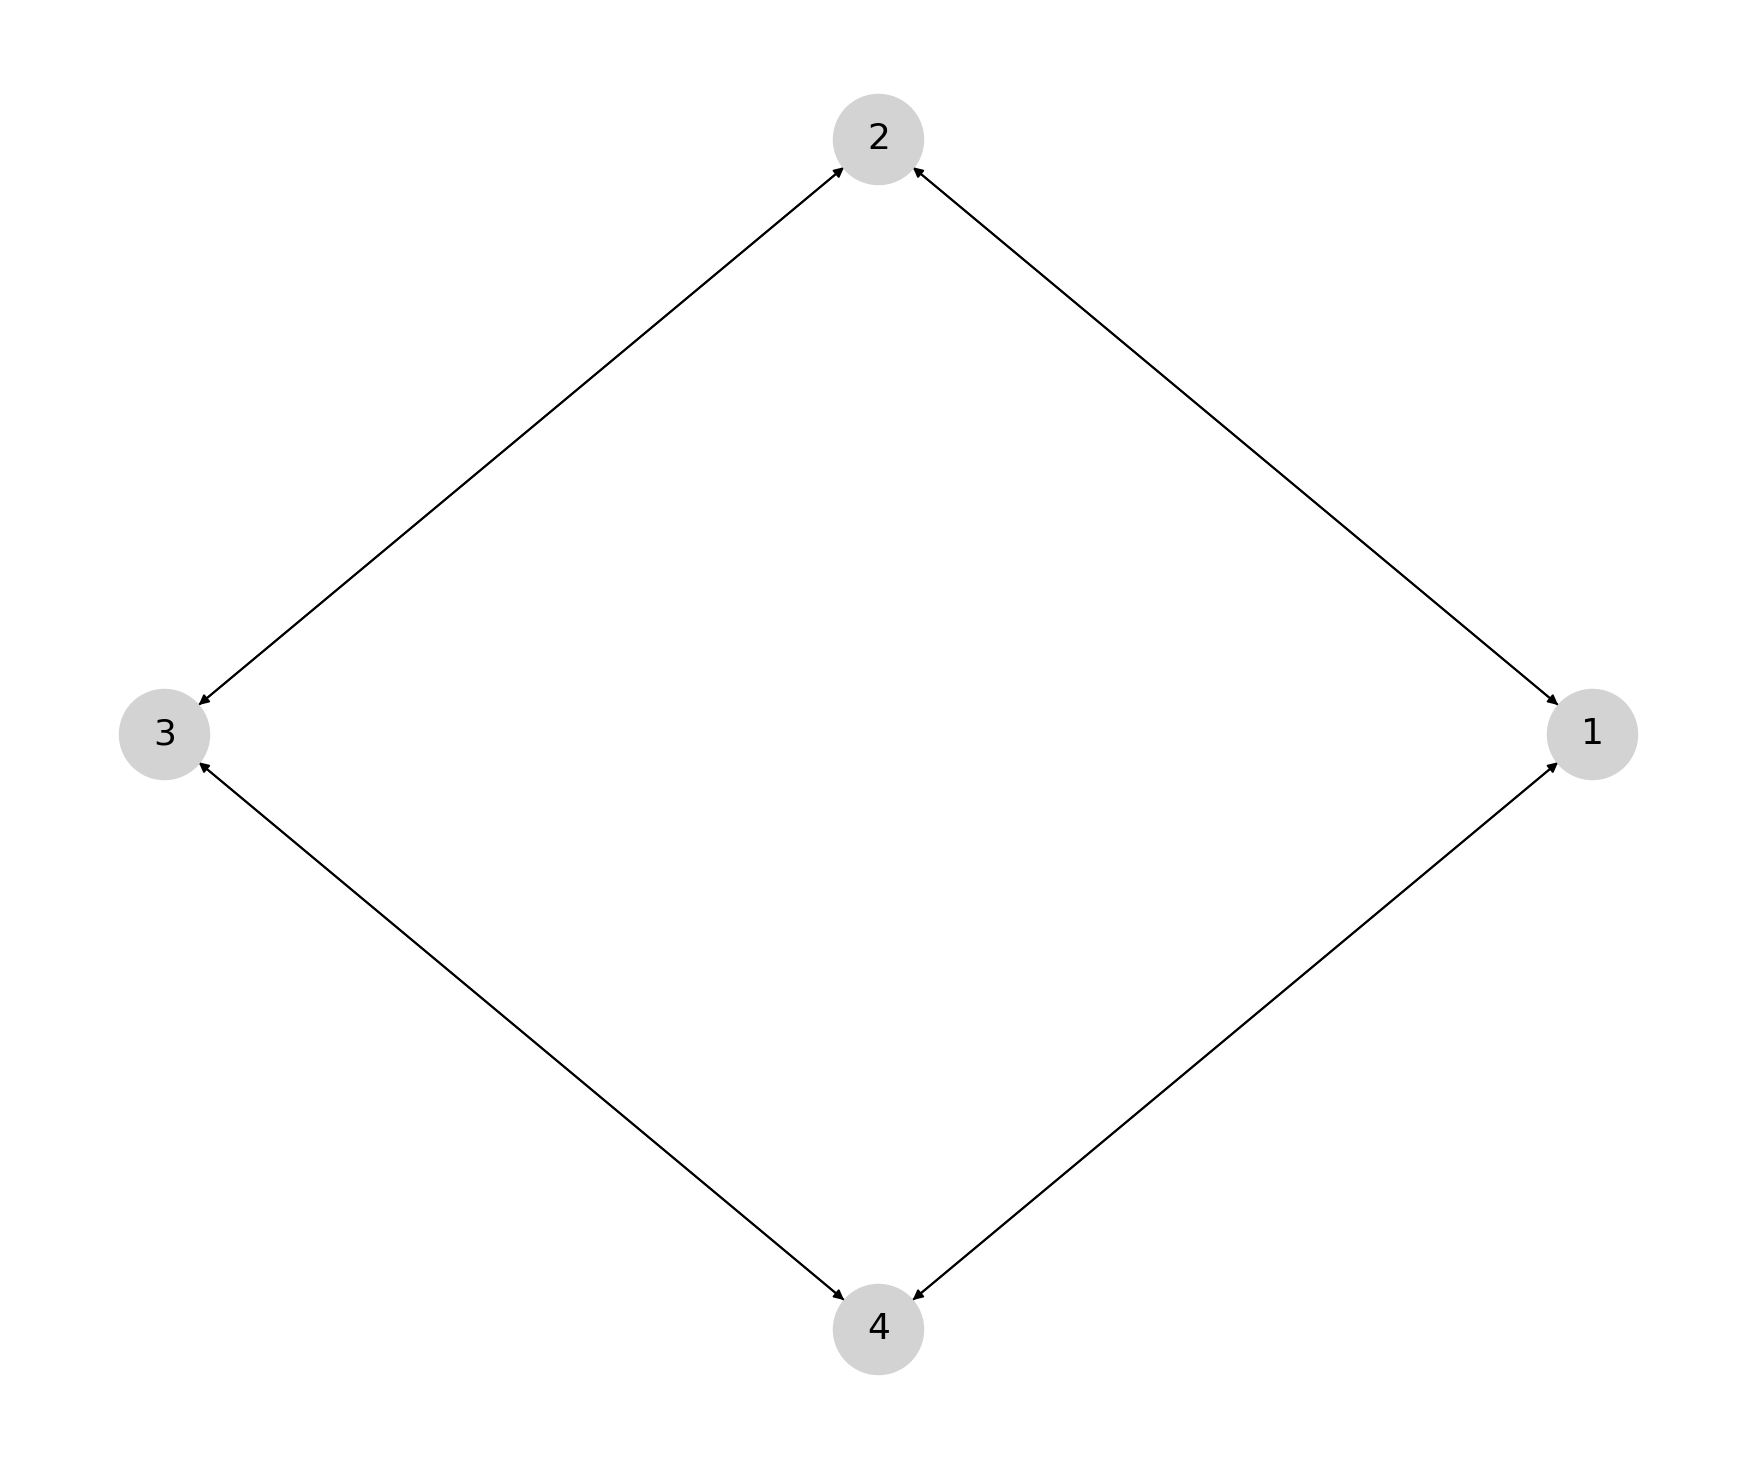

In [3]:
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_edge(1, 2)
G.add_edge(2, 1)
G.add_edge(1, 4)
G.add_edge(4, 1)
G.add_edge(3, 4)
G.add_edge(4, 3)
G.add_edge(3, 2)
G.add_edge(2, 3)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_node(4)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 4)
G_ud.add_edge(4, 1)
G_ud.add_edge(3, 4)
G_ud.add_edge(4, 3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)

nx.draw(G, 
        pos=nx.circular_layout(G), 
        with_labels=True, 
        node_size=2000, 
        node_color = 'lightgray', 
        font_size=18, 
        font_color='black', 
        font_family='sans-serif')

In [4]:
def autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3):
    """
    Calculates the analytical solution for autocorrelation function given a Laplacian matrix
    
    Parameters
    ----------
    observable : 1D array
        possible values of observable (which is a state function on the Markov process)
    L : 2D array
        column-based Laplacian matrix of system (including diagonal entries)
    tau_n : 1D array
        range of intervals between values of observable taken by system
    alpha : scalar
        exponent
    beta : scalar
        exponent
    
    Returns
    -------
    t : 1D array
        forward autocorrelation function values
    t_rev : 1D array
        reverse autocorrelation function values
    
    """
    f = np.array([observable])
    fstar = f.T
    
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
    
    # initialize forward and reverse autocorrelation function arrays
    t = np.zeros(len(tau_n))
    t_rev = np.zeros(len(tau_n))
    
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau_n))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau_n)):
        t[i] = f**alpha @ list_result[i] @(fstar ** beta * pi)
        t_rev[i] = f**beta @ list_result[i] @(fstar ** alpha * pi)
        
    return t, t_rev

In [5]:
signal = make_observable([1,2,3,4])
alpha, beta  = 1, 3
tau = np.linspace(0.01, 100, num=500)

print(signal)

[3. 5. 7. 9.]


0.0
[0.25 0.25 0.25 0.25]
1.1641532182693481e-10


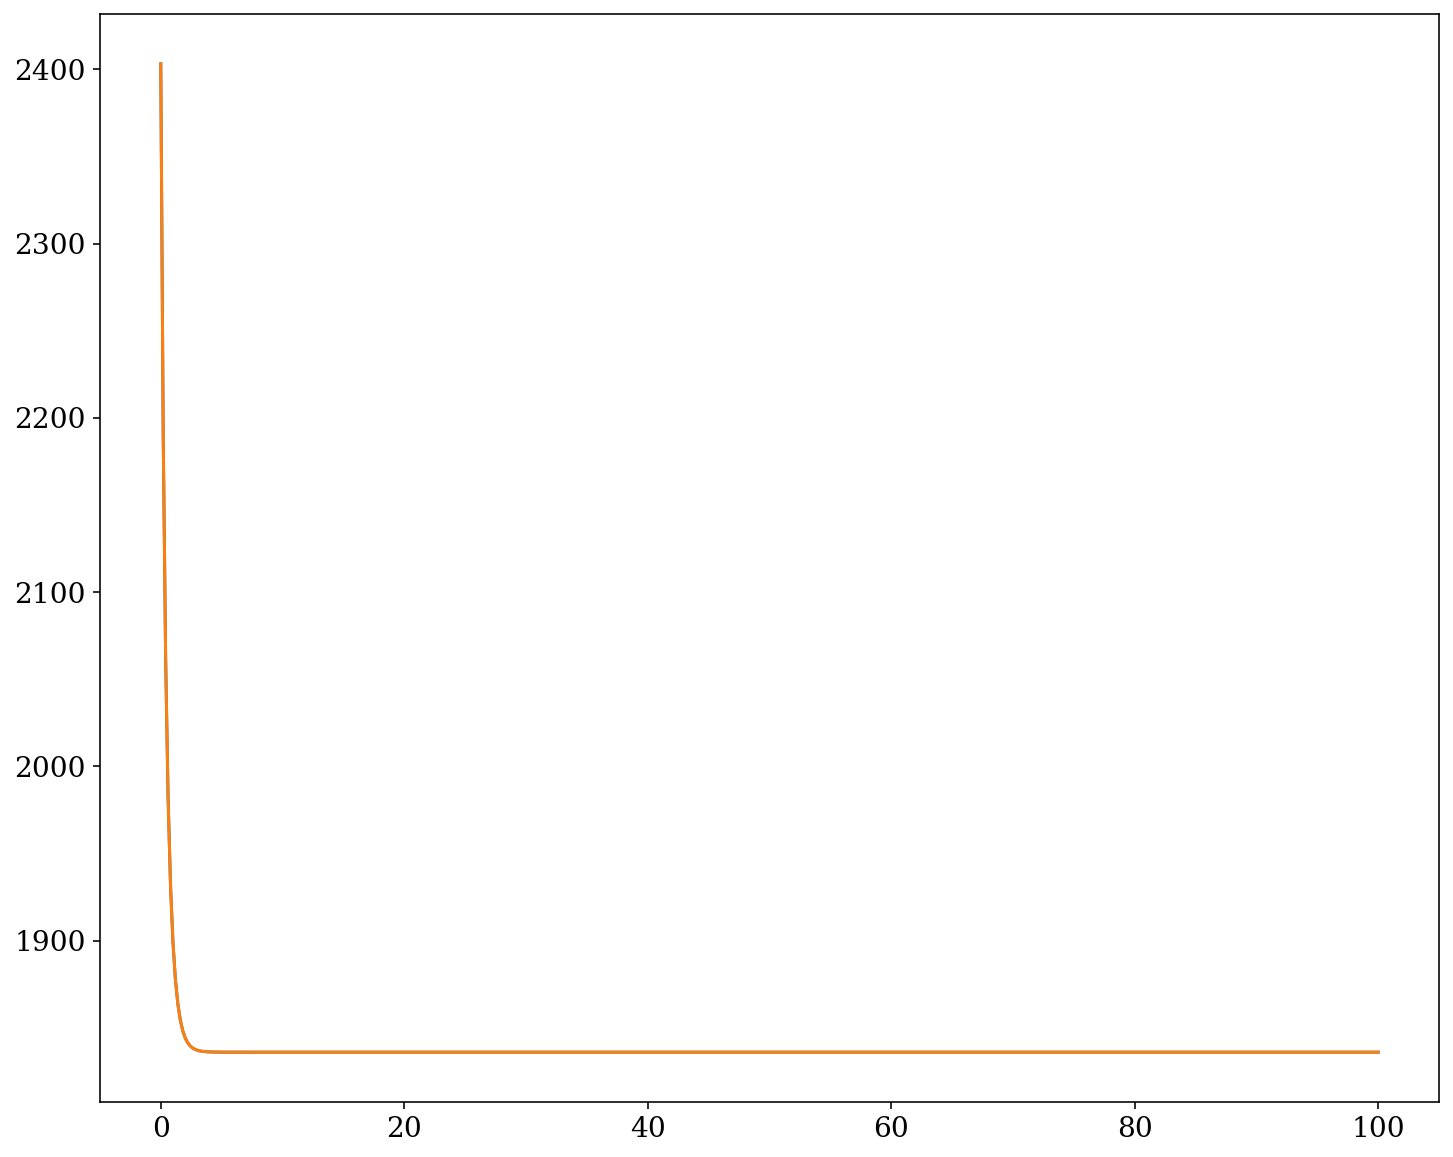

In [6]:
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

aff = np.log(np.prod(labels_f)/np.prod(labels_r))
print(aff)

lap = np.array([[-1.0-1.0, 1.0, 0, 1.0], [1.0, -1.0-1.0, 1.0, 0], [0, 1.0, -1.0-1.0, 1.0], [1.0, 0, 1.0, -1.0-1.0]])

eigvals, eigvecs = scipy.linalg.eig(lap)
pi_all = eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)
print(pi_all)

a_13, a_31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
stein = numerical_area(a_13, a_31)
print(stein)

plt.plot(tau, a_13)
plt.plot(tau, a_31)

In [7]:
N = 2000
all_affinities = np.empty(N, dtype=float)
all_areas = np.empty(N, dtype=float)
edge_idx = 0
perturb_edge = labels_f[edge_idx]

for i in tqdm(range(0,N)):
    
    # 1. update the edge label value for the chosen rate in label_dict, label_list    
    labels_f[edge_idx] = perturb_edge
    
    # 2. update the Laplacian
    lap = np.array([[-perturb_edge-1.0, 1.0, 0, 1.0], [perturb_edge, -1.0-1.0, 1.0, 0], [0, 1.0, -1.0-1.0, 1.0], [1.0, 0, 1.0, -1.0-1.0]],dtype=float)
    eigvals, eigvecs = scipy.linalg.eig(lap)
    pi_all = eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)
    
    # 3. calculate and store the affinity
    aff = np.log(np.prod(labels_f)/np.prod(labels_r))
    all_affinities[i] = aff
    
    # 4. calculate and store the Steinberg signature
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    all_areas[i] = numerical_area(a13,a31)
    
    # 5. perturb chosen parameter for next iteration 
    perturb_edge *= 1.01

100%|███████████████████████████████████████| 2000/2000 [03:09<00:00, 10.57it/s]


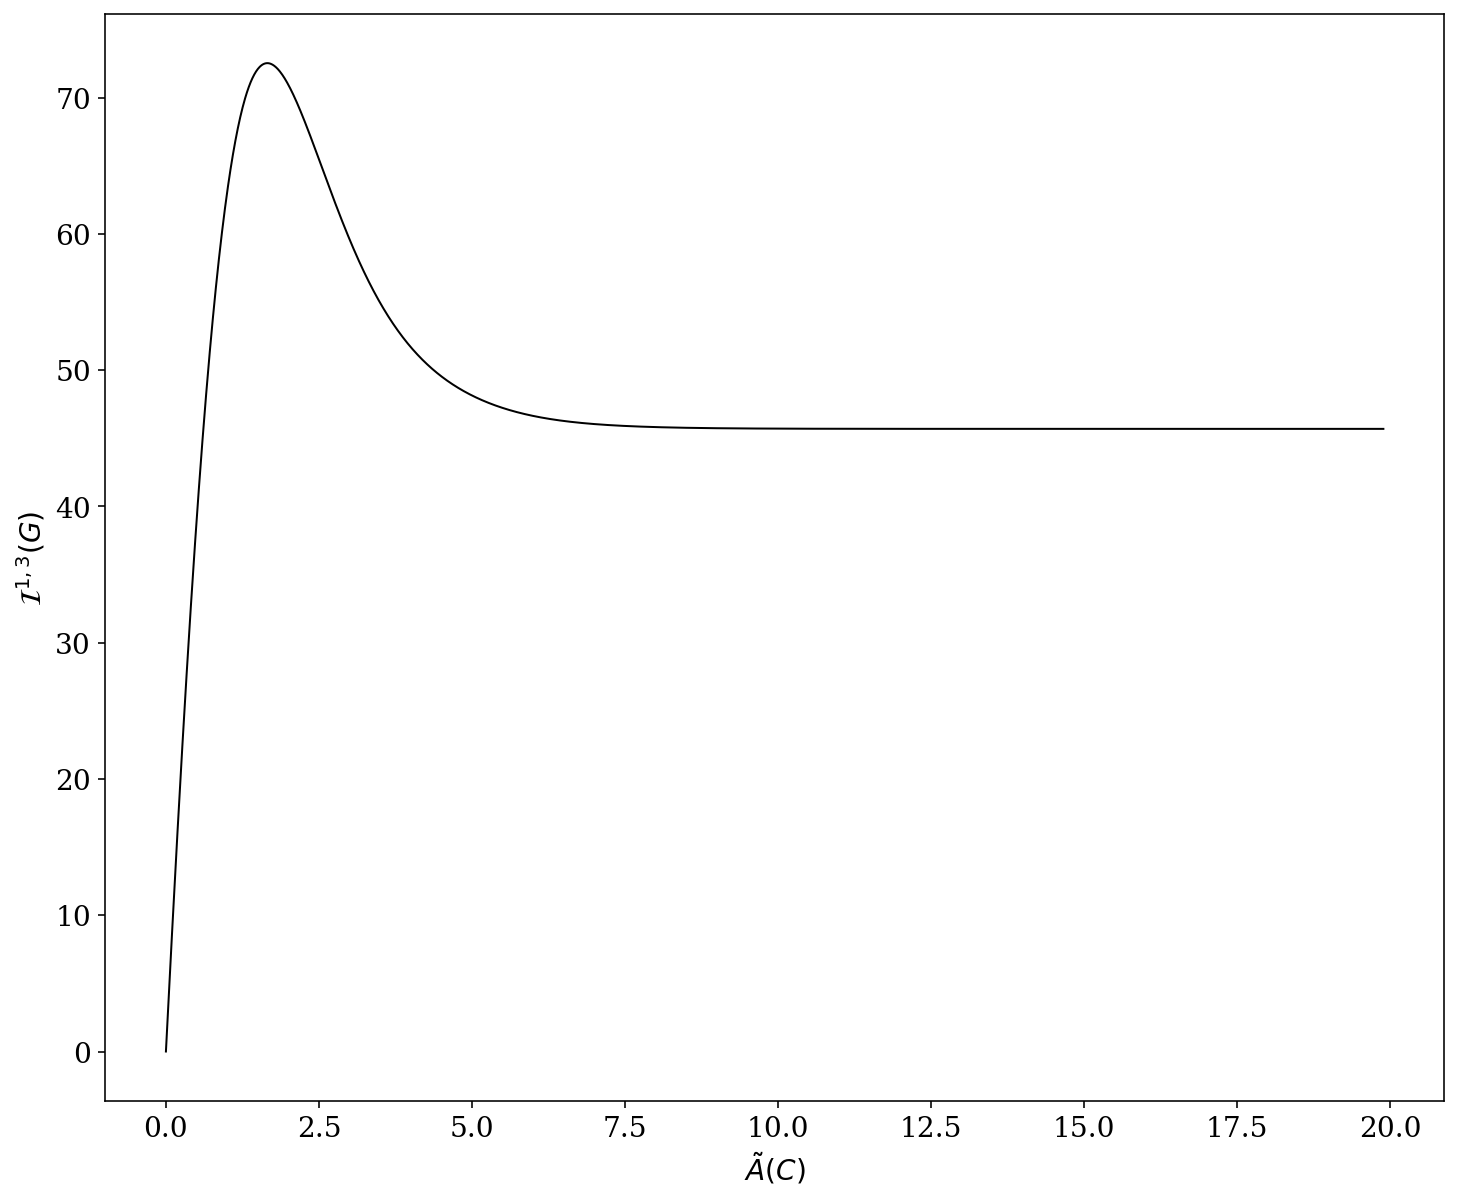

In [8]:
plt.plot(np.abs(all_affinities),all_areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

Figure 4B

In [9]:
def eq_k4(cycle_edges_forward,
          cycle_labels_forward,
          cycle_labels_backward,
          cycles):
    
    # choose edge to reset
    reset_edge = cycle_edges_forward[0][0]
    old_label = cycle_labels_forward[0][0]
    
    # recalculate its label
    prodf = np.prod(cycle_labels_forward[0])
    prodb = np.prod(cycle_labels_backward[0])
    new_label = prodb / (prodf / old_label)
    
    # update data structure
    cycle_labels_forward[0][0] = new_label
    
    # check affinity
    prodf1, prodb1 = calculate_cycle_products(cycle_labels_forward, cycle_labels_backward)
    affinity = calculate_affinities(prodf1, prodb1, cycles)
    print("Affinity after reset:", affinity)

    return cycle_labels_forward, reset_edge

def reformat_labels_k4(cycle_labels_forward,
                       label_dict,
                       edge_list,
                       reset_edge):
    """
    Update label_dict with the new forward labels you solved for,
    and rebuild a NumPy label list in the given edge_list.
    """
    
    # 1) Apply solved labels back into the dict
    label_dict[reset_edge] = cycle_labels_forward[0][0]

    # 2) Rebuild the label list in a consistent order
    label_list = np.array([ label_dict[edge] for edge in edge_list ], dtype=float)

    return label_dict, label_list

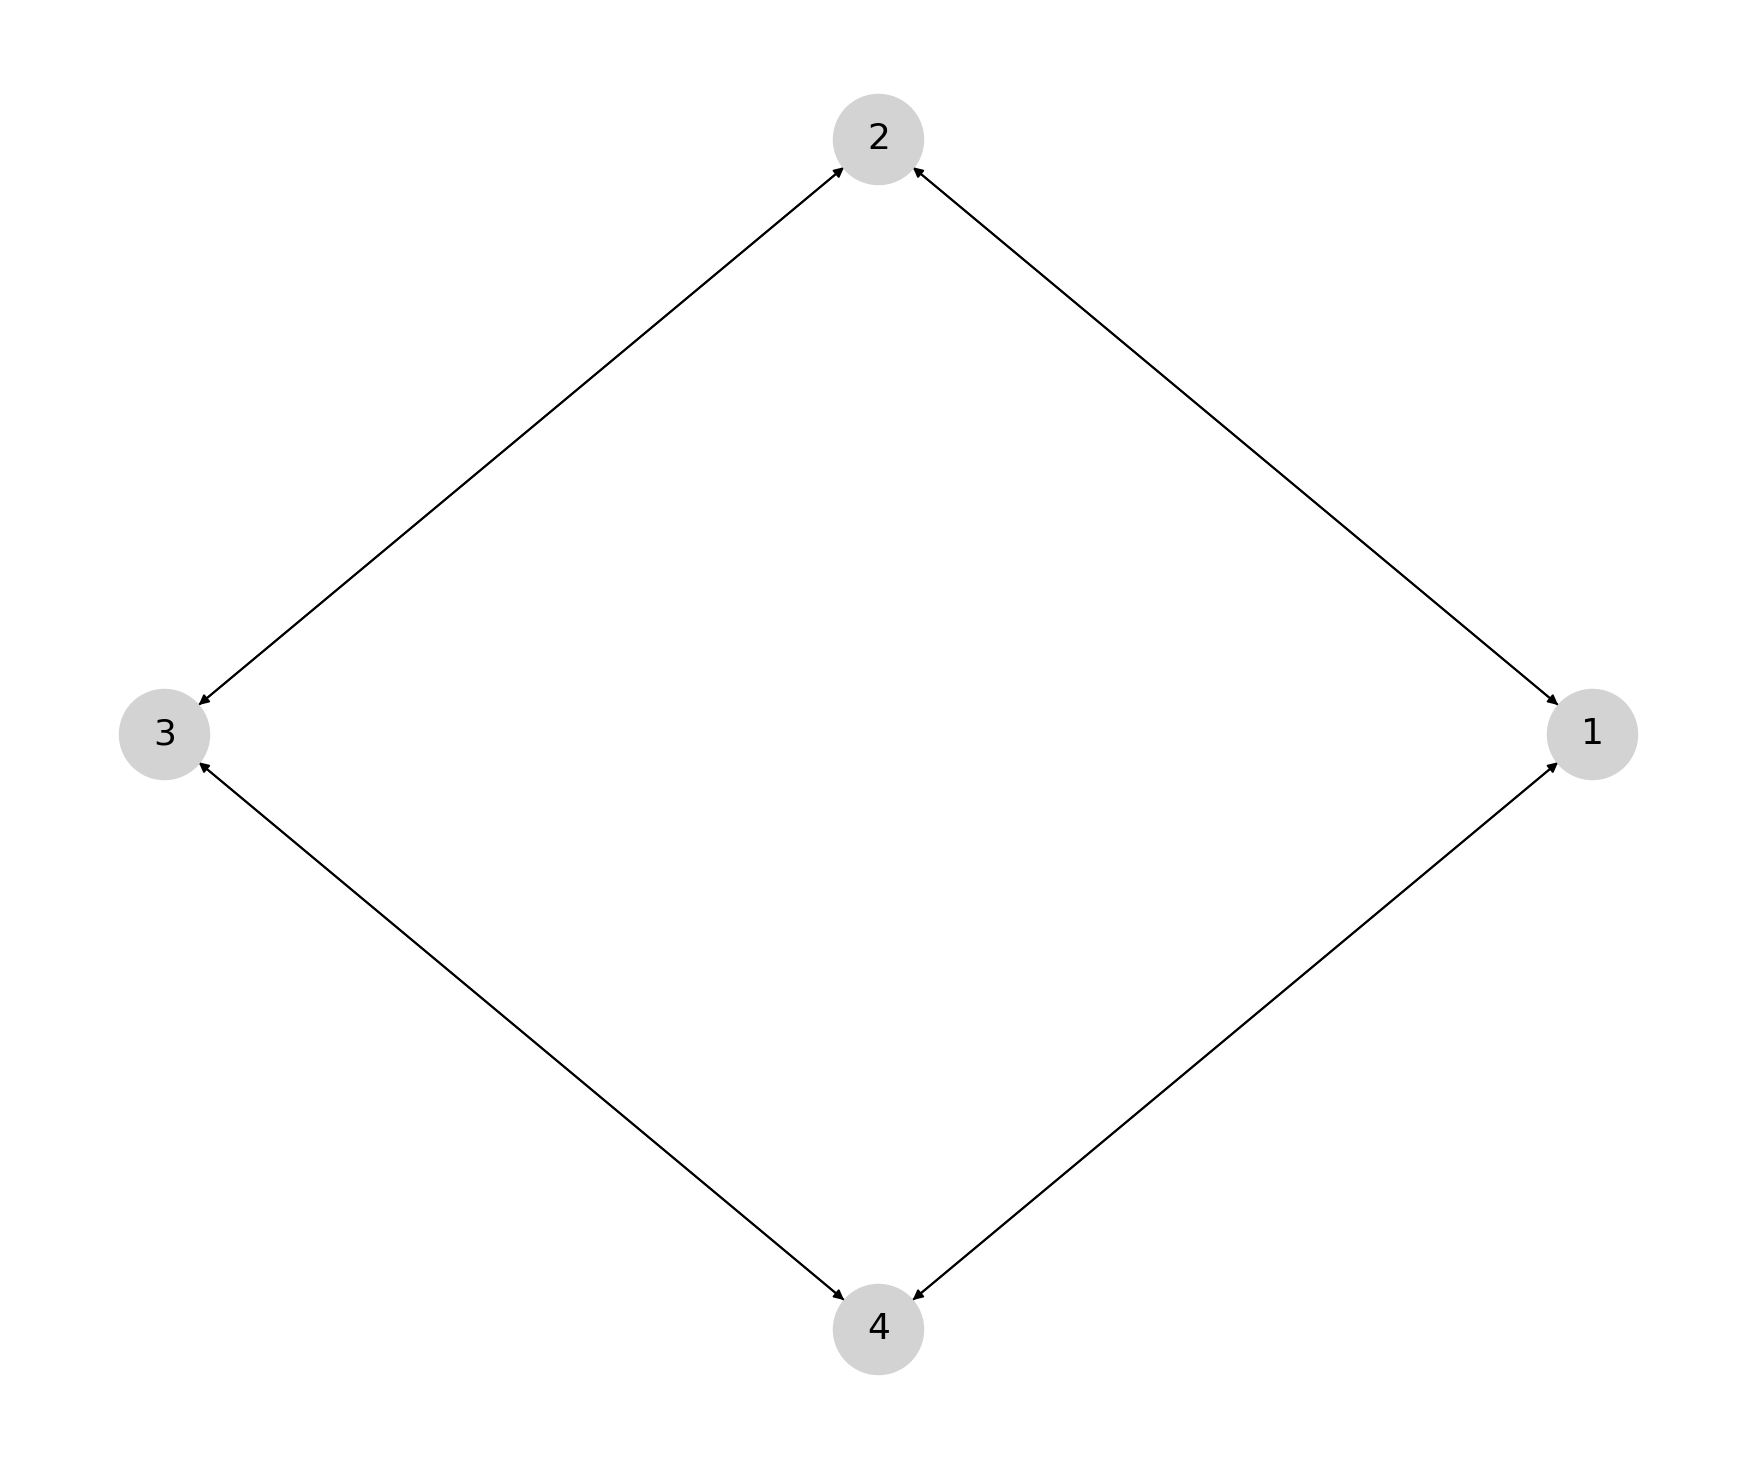

In [10]:
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_edge(1, 2)
G.add_edge(2, 1)
G.add_edge(1, 4)
G.add_edge(4, 1)
G.add_edge(3, 4)
G.add_edge(4, 3)
G.add_edge(3, 2)
G.add_edge(2, 3)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_node(4)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 4)
G_ud.add_edge(4, 1)
G_ud.add_edge(3, 4)
G_ud.add_edge(4, 3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)

nx.draw(G, 
        pos=nx.circular_layout(G), 
        with_labels=True, 
        node_size=2000, 
        node_color = 'lightgray', 
        font_size=18, 
        font_color='black', 
        font_family='sans-serif')

In [40]:
# all ones

edge_list = get_edges(G)        # list of (u,v) tuples
node_list = get_nodes(G)
# label the graph
label_dict,label_list = get_labels_ones(G,edge_list)
cycles = get_cycles(G_ud)
edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict)

print(label_dict)

# which edges are shared between cycles?
shared_edges, all_edges_f = shared_edges_cycles(cycles,
                                            edgesf,
                                            edgesb)

# set each cycle to thermodynamic equilibrium, output affinities
new_labelsf, edge_tracker, idx_tracker = equilibrium_params(cycles, edgesf, labelsf, labelsb, shared_edges)

# update graph's data structures 

# Update label_dict & build label_list in edge_list order:
new_label_dict, new_label_list = reformat_labels(edge_tracker,
                                                 idx_tracker,
                                                 new_labelsf,
                                                 label_dict,
                                                 edge_list)

label_dict = new_label_dict
label_list = new_label_list

edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict)
L  = Laplacian_all(edge_list, label_list, node_list)
pi = steady_state_spectrum(L)

perturb_edge = edgesf[0][2]
print(perturb_edge)

#----#

signal = make_observable(node_list)
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 4): 1.0, (3, 2): 1.0, (4, 1): 1.0, (4, 3): 1.0}
Cycle 0 affinity after solve: 0.0
(4, 1)


In [41]:
N = 2000
all_affinities = np.zeros((N,len(cycles)))
all_areas = np.zeros((N,1))

for i in tqdm(range(0,N)):
    
    # 1. update the edge label value for the chosen rate in label_dict, label_list    
    label_list = np.array([label_dict[e] for e in edge_list], dtype=float)
    edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict)
    
    # 2. update the Laplacian
    L = Laplacian_all(edge_list,label_list,node_list)
    
    # 3. calculate and store the affinity
    prodf, prodb = calculate_cycle_products(labelsf, labelsb)
    all_affinities[i] = calculate_affinities(prodf,prodb,cycles)
    
    # 4. calculate and store the Steinberg signature
    #tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)
    pi = steady_state_spectrum(L)
    a13, a31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas[i] = numerical_area(a13,a31)
    
    # 5. perturb chosen parameter for next iteration 
    label_dict[perturb_edge] *= 1.01

100%|███████████████████████████████████████| 2000/2000 [06:35<00:00,  5.05it/s]


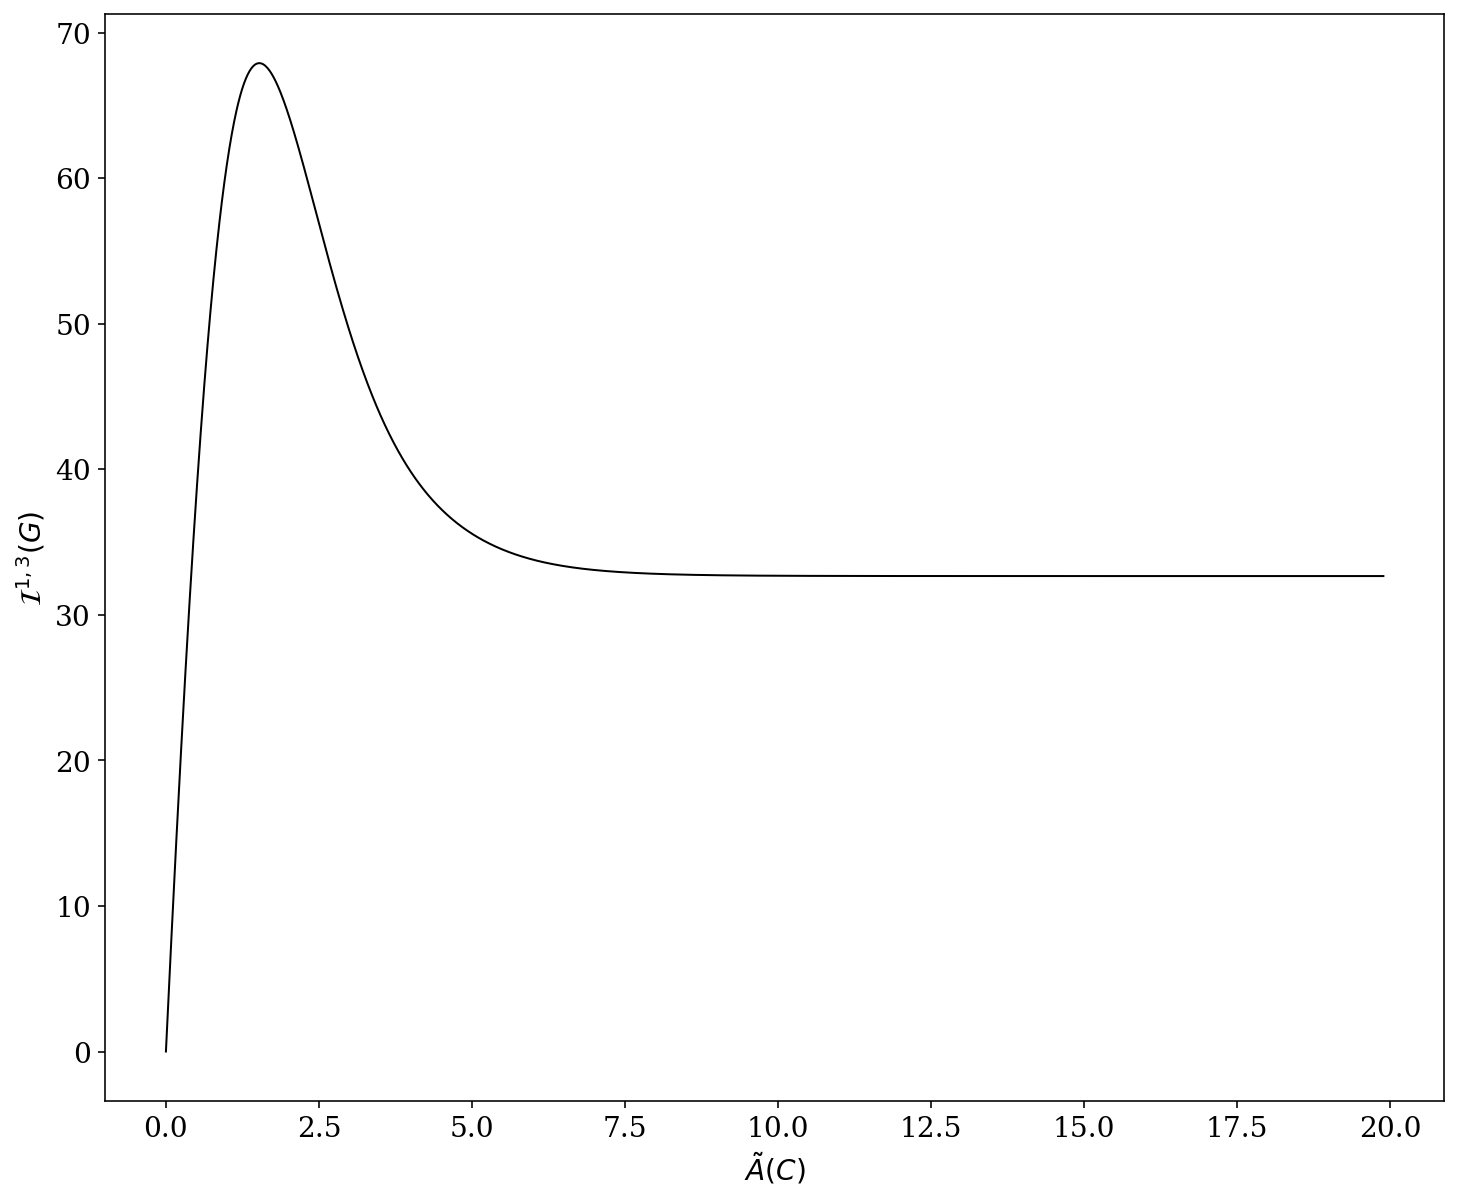

In [42]:
for i in range(len(cycles)):
    plt.plot(np.abs(all_affinities[:,0]),all_areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

In [75]:
# param_set1

seed = np.random.choice(np.arange(1,1000), size=1)[0]
print(seed)

np.random.seed(seed)

edge_list = get_edges(G)        # list of (u,v) tuples
node_list = get_nodes(G)
# label the graph
label_dict1,label_list = get_labels(G,edge_list)
cycles = get_cycles(G_ud)
edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict1)

print(label_dict1)

# which edges are shared between cycles?
#shared_edges, all_edges_f = shared_edges_cycles(cycles,
#                                            edgesf,
#                                            edgesb)

# set each cycle to thermodynamic equilibrium, output affinities
labelsf, reset_edge = eq_k4(edgesf,labelsf,labelsb,cycles)

#new_labelsf, edge_tracker, idx_tracker = equilibrium_params(cycles, edgesf, labelsf, labelsb, shared_edges)

# update graph's data structures 

# Update label_dict & build label_list in edge_list order:
new_label_dict, new_label_list = reformat_labels_k4(labelsf,
                                                    label_dict1,
                                                    edge_list,
                                                    reset_edge)

label_dict1 = new_label_dict
label_list = new_label_list

print(label_dict1)

edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict1)
L  = Laplacian_all(edge_list, label_list, node_list)
pi = steady_state_spectrum(L)

cycle_idx = 0
edge_idx = 2

print(edgesf)

perturb_edge = edgesf[cycle_idx][edge_idx]

print(perturb_edge)

#----#

signal = make_observable(node_list)
alpha, beta  = 1, 3

318
{(1, 2): 3.314, (1, 4): 0.1099, (2, 1): 0.05033, (2, 3): 0.00736, (3, 4): 0.2713, (3, 2): 0.02039, (4, 1): 0.001398, (4, 3): 30.0}
Affinity after reset: [0.]
{(1, 2): 3.314, (1, 4): 0.1099, (2, 1): 0.05033, (2, 3): 2.6918672209154177, (3, 4): 0.2713, (3, 2): 0.02039, (4, 1): 0.001398, (4, 3): 30.0}
[[(2, 3), (3, 4), (4, 1), (1, 2)]]
(4, 1)


In [76]:
N = 2000
all_affinities1 = np.zeros((N,len(cycles)))
all_areas1 = np.zeros((N,1))

for i in tqdm(range(0,N)):
    
    # 1. update the edge label value for the chosen rate in label_dict, label_list    
    label_list = np.array([label_dict1[e] for e in edge_list], dtype=float)
    edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict1)
    
    # 2. update the Laplacian
    L = Laplacian_all(edge_list,label_list,node_list)
    
    # 3. calculate and store the affinity
    prodf, prodb = calculate_cycle_products(labelsf, labelsb)
    all_affinities1[i] = calculate_affinities(prodf,prodb,cycles)
    
    # 4. calculate and store the Steinberg signature
    tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)
    pi = steady_state_spectrum(L)
    a13, a31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas1[i] = numerical_area(a13,a31)
    
    # 5. perturb chosen parameter for next iteration 
    label_dict1[perturb_edge] *= 1.01

100%|███████████████████████████████████████| 2000/2000 [02:54<00:00, 11.48it/s]


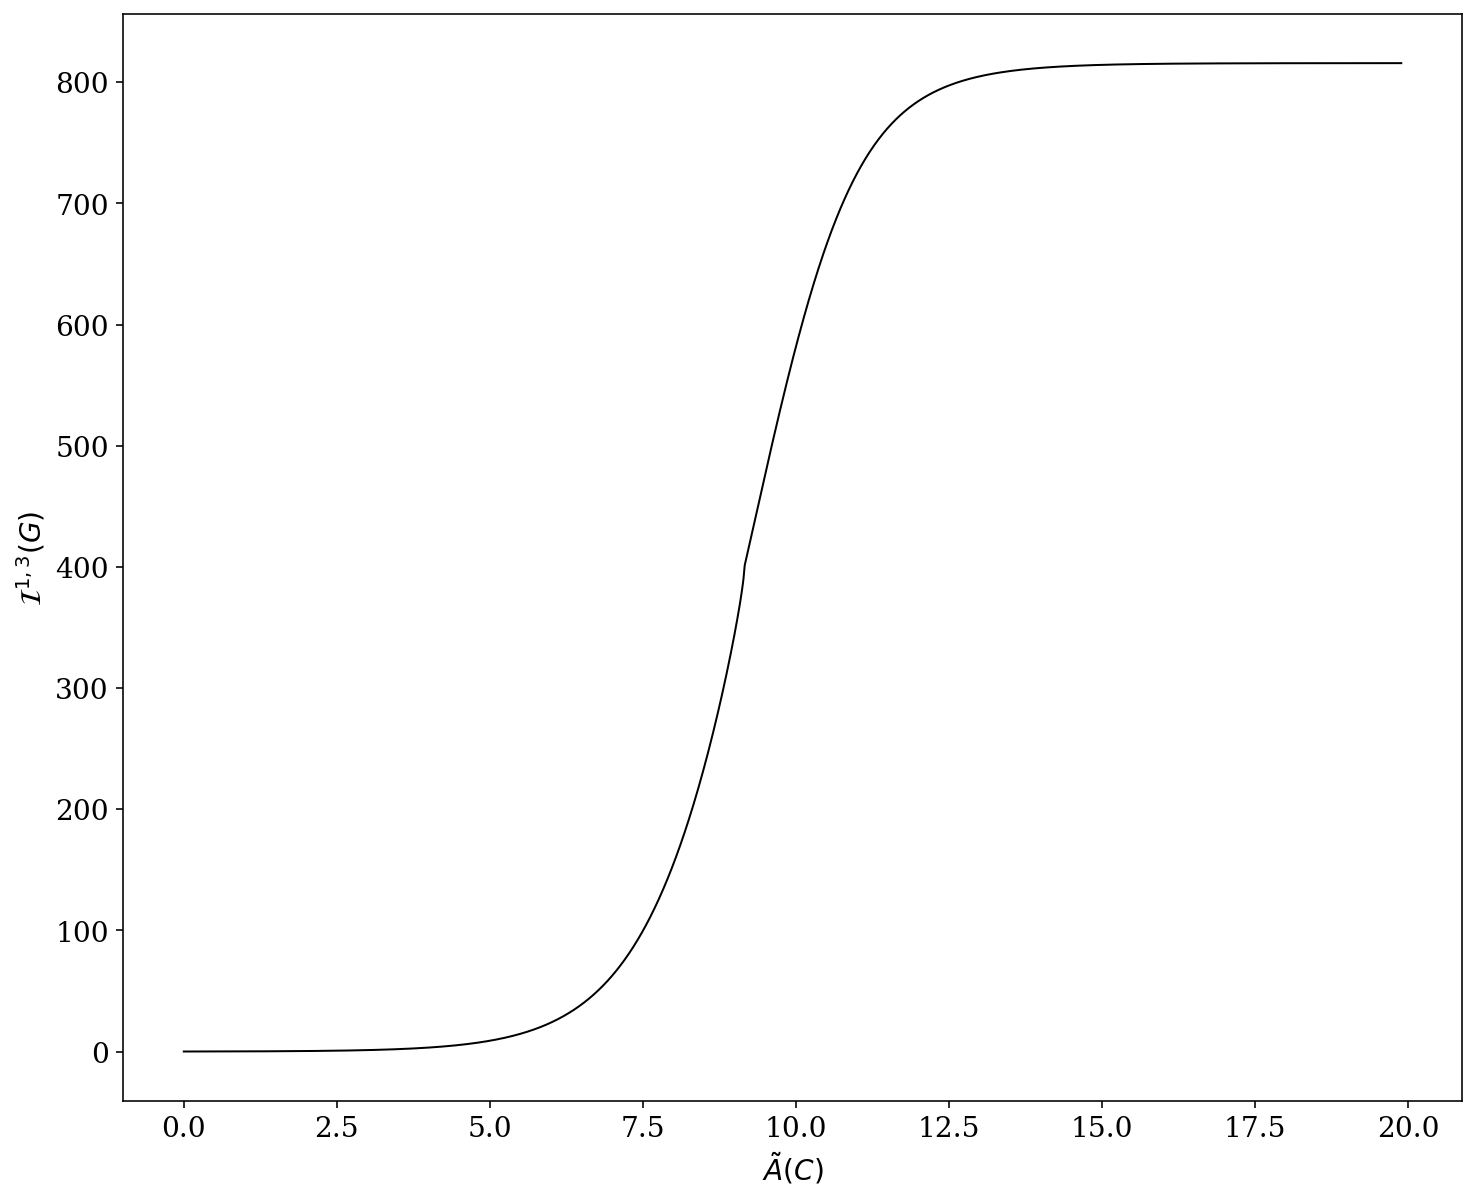

In [77]:
for i in range(len(cycles)):
    plt.plot(np.abs(all_affinities1[:,0]),all_areas1,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

In [73]:
# param_set2

seed = 700 #np.random.choice(np.arange(1,1000), size=1)
print(seed)

np.random.seed(seed)

edge_list = get_edges(G)        # list of (u,v) tuples
node_list = get_nodes(G)
# label the graph
label_dict2,label_list = get_labels(G,edge_list)
cycles = get_cycles(G_ud)
edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict2)

print(label_dict2)

# which edges are shared between cycles?
shared_edges, all_edges_f = shared_edges_cycles(cycles,
                                            edgesf,
                                            edgesb)

# set each cycle to thermodynamic equilibrium, output affinities
new_labelsf, edge_tracker, idx_tracker = equilibrium_params(cycles, edgesf, labelsf, labelsb, shared_edges)

# update graph's data structures 

# Update label_dict & build label_list in edge_list order:
new_label_dict, new_label_list = reformat_labels(edge_tracker,
                                                 idx_tracker,
                                                 new_labelsf,
                                                 label_dict2,
                                                 edge_list)

label_dict2 = new_label_dict
label_list = new_label_list

print(label_dict2)

edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict2)
L  = Laplacian_all(edge_list, label_list, node_list)
pi = steady_state_spectrum(L)

cycle_idx = 0
edge_idx = 0

print(edgesf)

perturb_edge = edgesf[cycle_idx][edge_idx]

print(perturb_edge)

#----#

signal = make_observable(node_list)
alpha, beta  = 1, 3

700
{(1, 2): 0.008695, (1, 4): 0.3171, (2, 1): 0.002517, (2, 3): 155.8, (3, 4): 0.06513, (3, 2): 28.02, (4, 1): 0.2901, (4, 3): 0.1177}
Cycle 0 affinity after solve: -1.1102230246251565e-16
{(1, 2): 0.008695, (1, 4): 0.3171, (2, 1): 0.002517, (2, 3): 16.022329473190215, (3, 4): 0.06513, (3, 2): 28.02, (4, 1): 0.2901, (4, 3): 0.1177}
[[(2, 3), (3, 4), (4, 1), (1, 2)]]
(2, 3)


In [17]:
N = 2000
all_affinities2 = np.zeros((N,len(cycles)))
all_areas2 = np.zeros((N,1))

for i in tqdm(range(0,N)):
    
    # 1. update the edge label value for the chosen rate in label_dict, label_list    
    label_list = np.array([label_dict2[e] for e in edge_list], dtype=float)
    edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict2)
    
    # 2. update the Laplacian
    L = Laplacian_all(edge_list,label_list,node_list)
    
    # 3. calculate and store the affinity
    prodf, prodb = calculate_cycle_products(labelsf, labelsb)
    all_affinities2[i] = calculate_affinities(prodf,prodb,cycles)
    
    # 4. calculate and store the Steinberg signature
    tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)
    pi = steady_state_spectrum(L)
    a13, a31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas2[i] = numerical_area(a13,a31)
    
    # 5. perturb chosen parameter for next iteration 
    label_dict2[perturb_edge] *= 1.01

100%|███████████████████████████████████████| 2000/2000 [02:55<00:00, 11.37it/s]


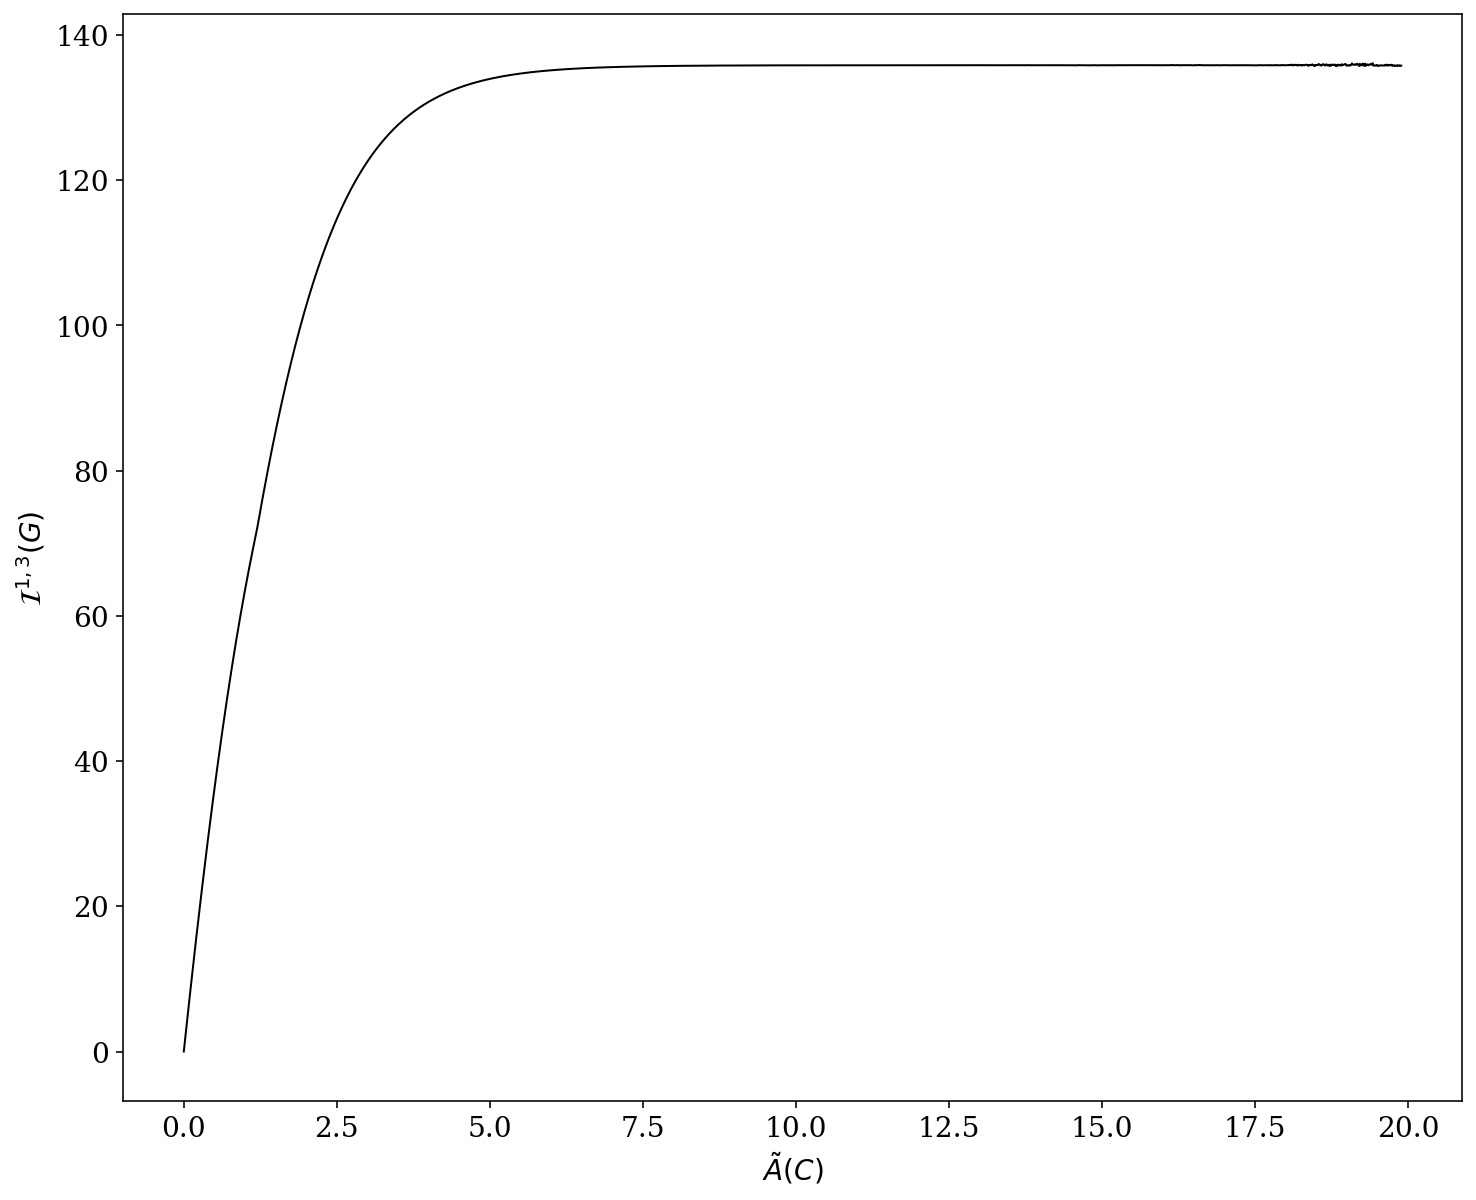

In [18]:
for i in range(len(cycles)):
    plt.plot(np.abs(all_affinities2[:,0]),all_areas2,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

In [68]:
# param_set3

seed = 524 
#np.random.choice(np.arange(1,1000), size=1)
print(seed)

np.random.seed(seed)

edge_list = get_edges(G)        # list of (u,v) tuples
node_list = get_nodes(G)
# label the graph
label_dict3,label_list = get_labels(G,edge_list)
cycles = get_cycles(G_ud)
edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict3)

print(label_dict3)

# which edges are shared between cycles?
shared_edges, all_edges_f = shared_edges_cycles(cycles,
                                            edgesf,
                                            edgesb)

# set each cycle to thermodynamic equilibrium, output affinities
new_labelsf, edge_tracker, idx_tracker = equilibrium_params(cycles, edgesf, labelsf, labelsb, shared_edges)

# update graph's data structures 

# Update label_dict & build label_list in edge_list order:
new_label_dict, new_label_list = reformat_labels(edge_tracker,
                                                 idx_tracker,
                                                 new_labelsf,
                                                 label_dict3,
                                                 edge_list)

label_dict3 = new_label_dict
label_list = new_label_list

print(label_dict3)

edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict3)
L  = Laplacian_all(edge_list, label_list, node_list)
pi = steady_state_spectrum(L)

cycle_idx = 0
edge_idx = 1

print(edgesf)

perturb_edge = edgesf[cycle_idx][edge_idx]

print(perturb_edge)

#----#

signal = make_observable(node_list)
alpha, beta  = 1, 3
#tau = np.linspace(0.01, 500, num=500)

524
{(1, 2): 5.154, (1, 4): 0.2267, (2, 1): 0.01257, (2, 3): 288.1, (3, 4): 2.321, (3, 2): 2.29, (4, 1): 0.4464, (4, 3): 15.02}
Cycle 0 affinity after solve: 0.0
{(1, 2): 5.154, (1, 4): 0.2267, (2, 1): 0.01257, (2, 3): 0.0183547499419828, (3, 4): 2.321, (3, 2): 2.29, (4, 1): 0.4464, (4, 3): 15.02}
[[(2, 3), (3, 4), (4, 1), (1, 2)]]
(3, 4)


In [69]:
N = 2000
all_affinities3 = np.zeros((N,len(cycles)))
all_areas3 = np.zeros((N,1))

for i in tqdm(range(0,N)):
    
    # 1. update the edge label value for the chosen rate in label_dict, label_list    
    label_list = np.array([label_dict3[e] for e in edge_list], dtype=float)
    edgesf, edgesb, labelsf, labelsb = get_cycle_labels_edges(cycles, label_dict3)
    
    # 2. update the Laplacian
    L = Laplacian_all(edge_list,label_list,node_list)
    
    # 3. calculate and store the affinity
    prodf, prodb = calculate_cycle_products(labelsf, labelsb)
    all_affinities3[i] = calculate_affinities(prodf,prodb,cycles)
    
    # 4. calculate and store the Steinberg signature
    tau, _ = define_tau_range(L, max_points=500, cap_factor=10.0)
    pi = steady_state_spectrum(L)
    a13, a31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas3[i] = numerical_area(a13,a31)
    
    # 5. perturb chosen parameter for next iteration 
    label_dict3[perturb_edge] *= 1.01

100%|███████████████████████████████████████| 2000/2000 [02:54<00:00, 11.46it/s]


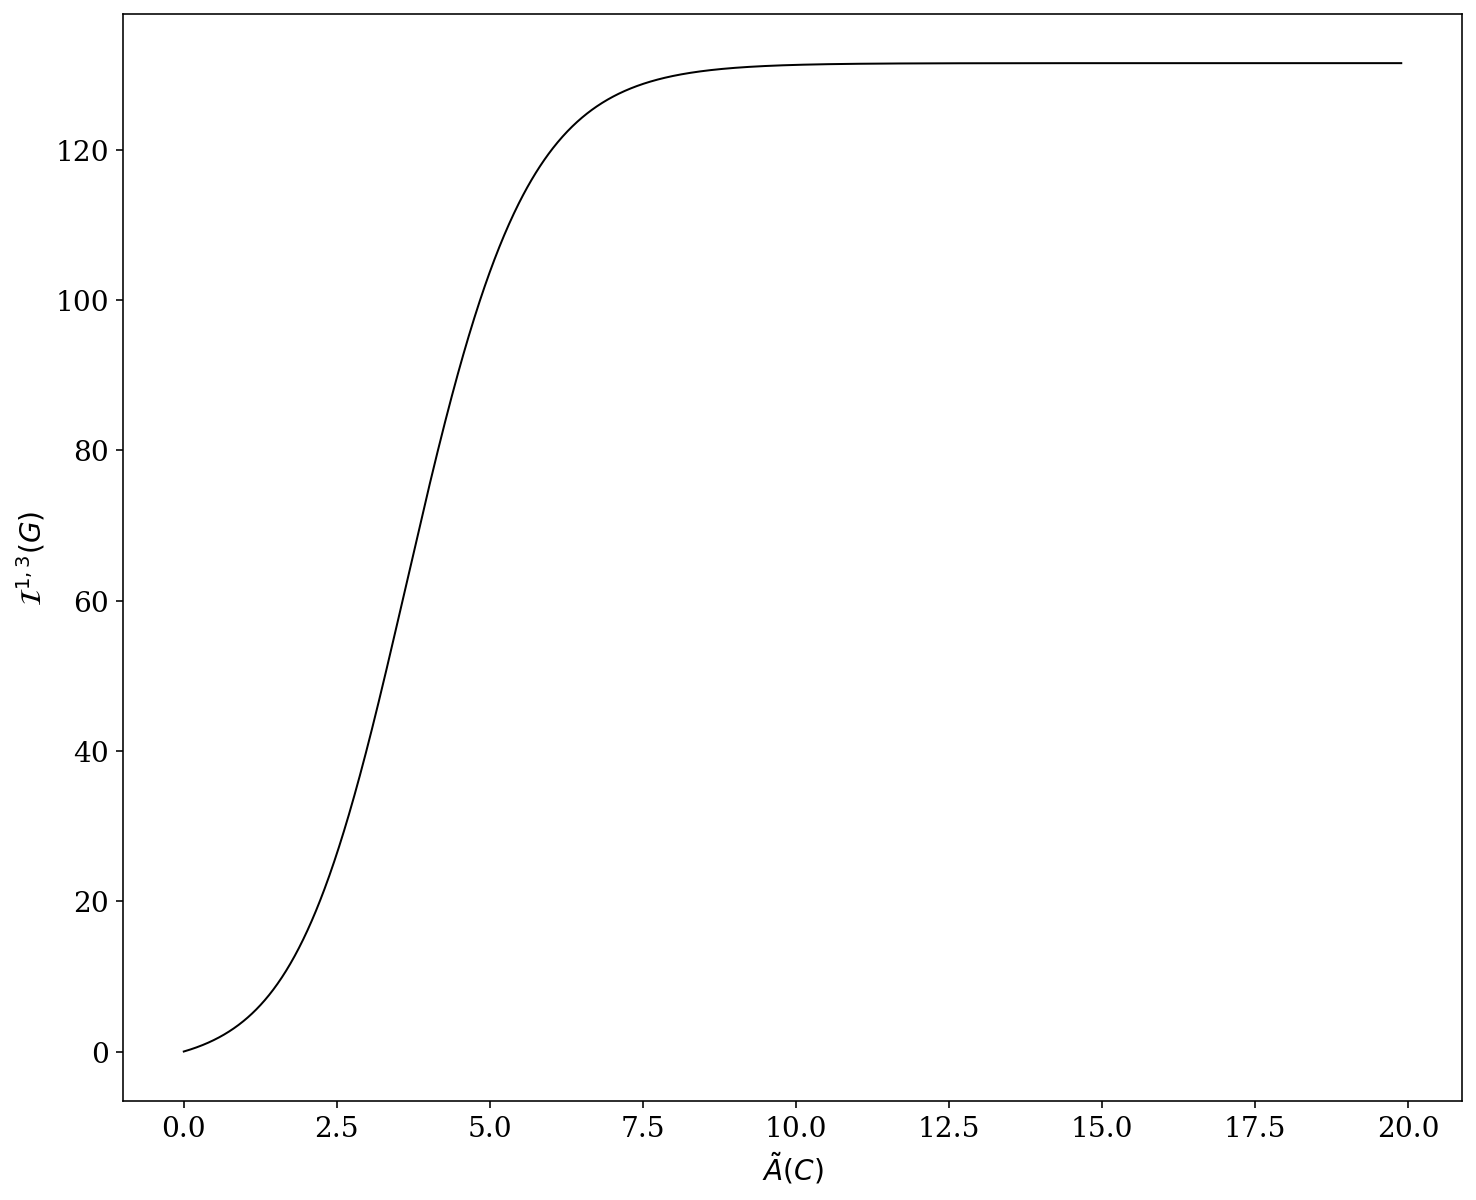

In [70]:
for i in range(len(cycles)):
    plt.plot(np.abs(all_affinities3[:,0]),all_areas3,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

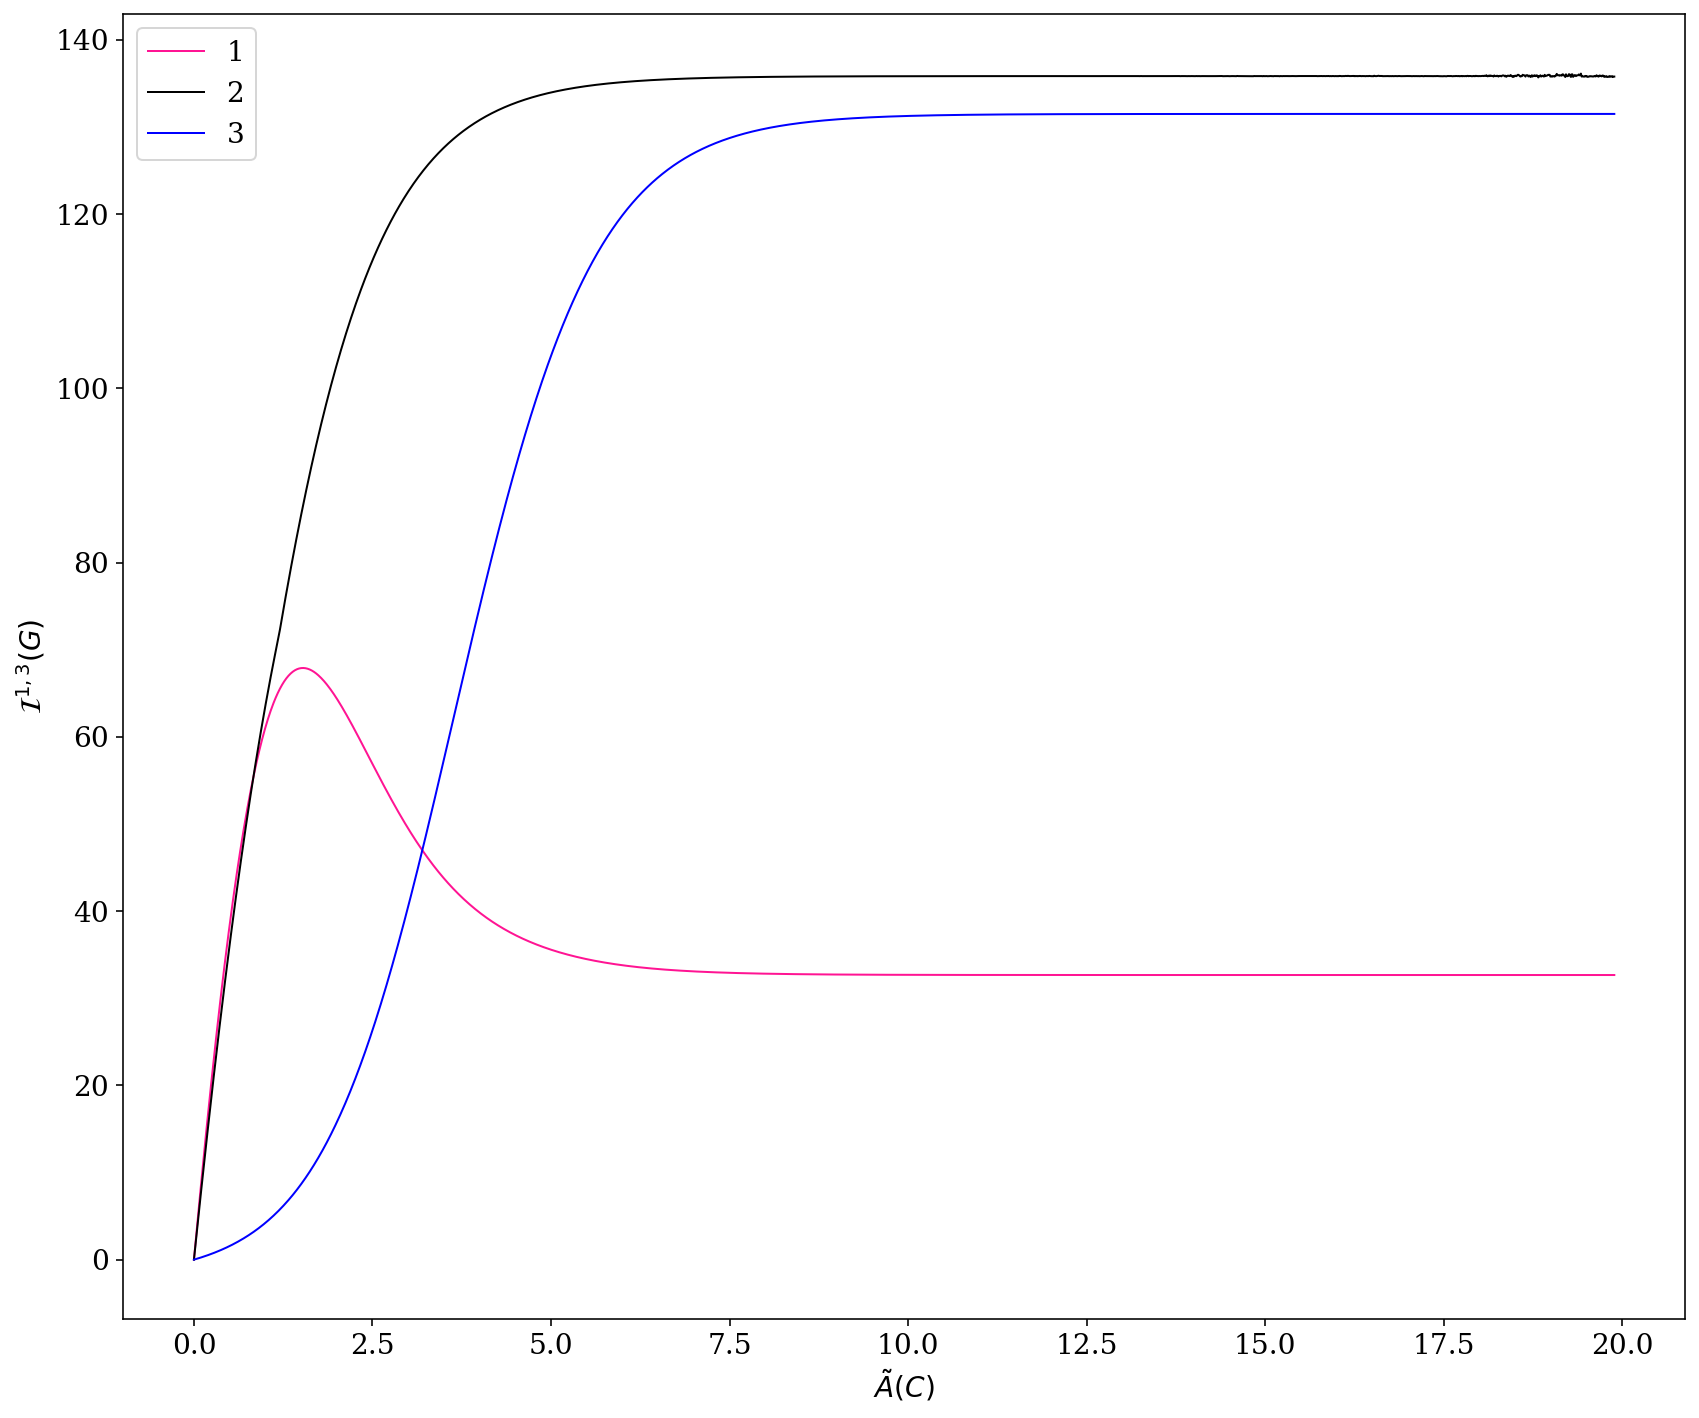

In [71]:
fig, ax = plt.subplots(figsize = (14, 12))

plt.plot(np.abs(all_affinities[:,0]),all_areas,linewidth=1, color= 'deeppink',label='1')
plt.plot(np.abs(all_affinities2[:,0]),all_areas2,linewidth=1, color = 'black', label = '2')
plt.plot(np.abs(all_affinities3[:,0]),all_areas3,linewidth=1, color = 'blue', label = '3')

plt.legend()
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()
fig.savefig('4Bnew.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
num_simulations = 20
num_perturbations = 2000
num_params = 8

mega_affinities = np.zeros((num_simulations,num_perturbations))
mega_areas = np.zeros((num_simulations,num_perturbations))

for j in range(num_simulations):
    
    # arrays for force/area tracking
    affinities = np.zeros(num_perturbations)
    areas = np.zeros(num_perturbations)
    
    # reset the initial equilibrium parameters
    params = equilibrium_parameters()
    print(params)
    
    # determine which parameter to perturb from its equilibrium value
    param_choice = np.random.choice(np.arange(0,6),size=1)[0]
    print(param_choice)
    
    # equilibrium conditions
    affinities[0] = cycle_affinity_K(params)
    L = Laplacian_K(params)
    tau, tau_max = define_tau_range(L, max_points=500, cap_factor=10.0)
    pi = steady_state_MTT_K(params)
    
    a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    areas[0] = numerical_area(a_13, a_31)
    
    for i in tqdm(range(1,num_perturbations)):
        params[param_choice] = params[param_choice]*1.01

        affinities[i] = cycle_affinity_K(params)

        L = Laplacian_K(params)
        tau, tau_max = define_tau_range(L, max_points=500, cap_factor=10.0)
        pi = steady_state_MTT_K(params)

        a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)

        areas[i] = numerical_area(a_13,a_31)
    
    mega_affinities[j,] = affinities
    mega_areas[j,] = areas